In [64]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
from bson import json_util


mongo_client = MongoClient('mongodb://localhost:27017/')
db = mongo_client['tiktokDB']
collection = db['tiktok']
collection_cluster = db['tiktok_cluster']
data = collection.find({})


                        _id                   label  \
0  65646b8bdc6eeb57b85b0ff1  partai amanat nasional   
1  65646b8bdc6eeb57b85b0ff2  partai amanat nasional   
2  65646b8bdc6eeb57b85b0ff3  partai amanat nasional   
3  65646b8bdc6eeb57b85b0ff4  partai amanat nasional   
4  65646b8bdc6eeb57b85b0ff5  partai amanat nasional   

                                           url_video    like  comment  \
0  https://www.tiktok.com/@putri_zulhas/video/727...   74700      920   
1  https://www.tiktok.com/@amanat_nasional/video/...  325400    13200   
2  https://www.tiktok.com/@putri_zulhas/video/729...   93700      794   
3  https://www.tiktok.com/@anakbawang619/video/72...    2118       22   
4  https://www.tiktok.com/@putri_zulhas/video/726...  133600     1942   

     views  share   save     tanggal  engagement_total  
0  2500000    498   2446  1693406580             78564  
1  3500000   6198  13700  1698207667            358498  
2  1700000    371   2700  1697375208             97565  
3 

c:\Users\user\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarni

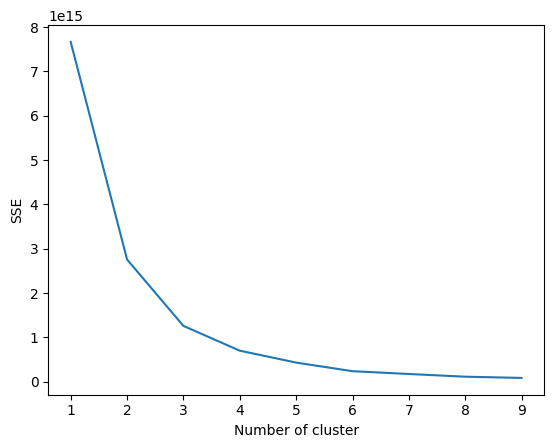

In [58]:
# get data from mongodb

df = pd.DataFrame(data)
print(df.head())

# decide the number of clusters using elbow method
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(df[['views', 'engagement_total']])
    df["cluster"] = kmeans.labels_
    sse[k] = kmeans.inertia_  # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


In [59]:
cluster = KMeans(n_clusters=4).fit(df[['views', 'engagement_total']])
df['cluster'] = cluster.labels_
# insert to tiktok_cluster
collection_cluster.delete_many({})
collection_cluster.insert_many(df.to_dict('records'))
print(df)


                           _id                   label  \
0     65646b8bdc6eeb57b85b0ff1  partai amanat nasional   
1     65646b8bdc6eeb57b85b0ff2  partai amanat nasional   
2     65646b8bdc6eeb57b85b0ff3  partai amanat nasional   
3     65646b8bdc6eeb57b85b0ff4  partai amanat nasional   
4     65646b8bdc6eeb57b85b0ff5  partai amanat nasional   
...                        ...                     ...   
3795  65646b8bdc6eeb57b85b1ec4            partai ummat   
3796  65646b8bdc6eeb57b85b1ec5            partai ummat   
3797  65646b8bdc6eeb57b85b1ec6            partai ummat   
3798  65646b8bdc6eeb57b85b1ec7            partai ummat   
3799  65646b8bdc6eeb57b85b1ec8            partai ummat   

                                              url_video    like  comment  \
0     https://www.tiktok.com/@putri_zulhas/video/727...   74700      920   
1     https://www.tiktok.com/@amanat_nasional/video/...  325400    13200   
2     https://www.tiktok.com/@putri_zulhas/video/729...   93700      794   

c:\Users\user\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


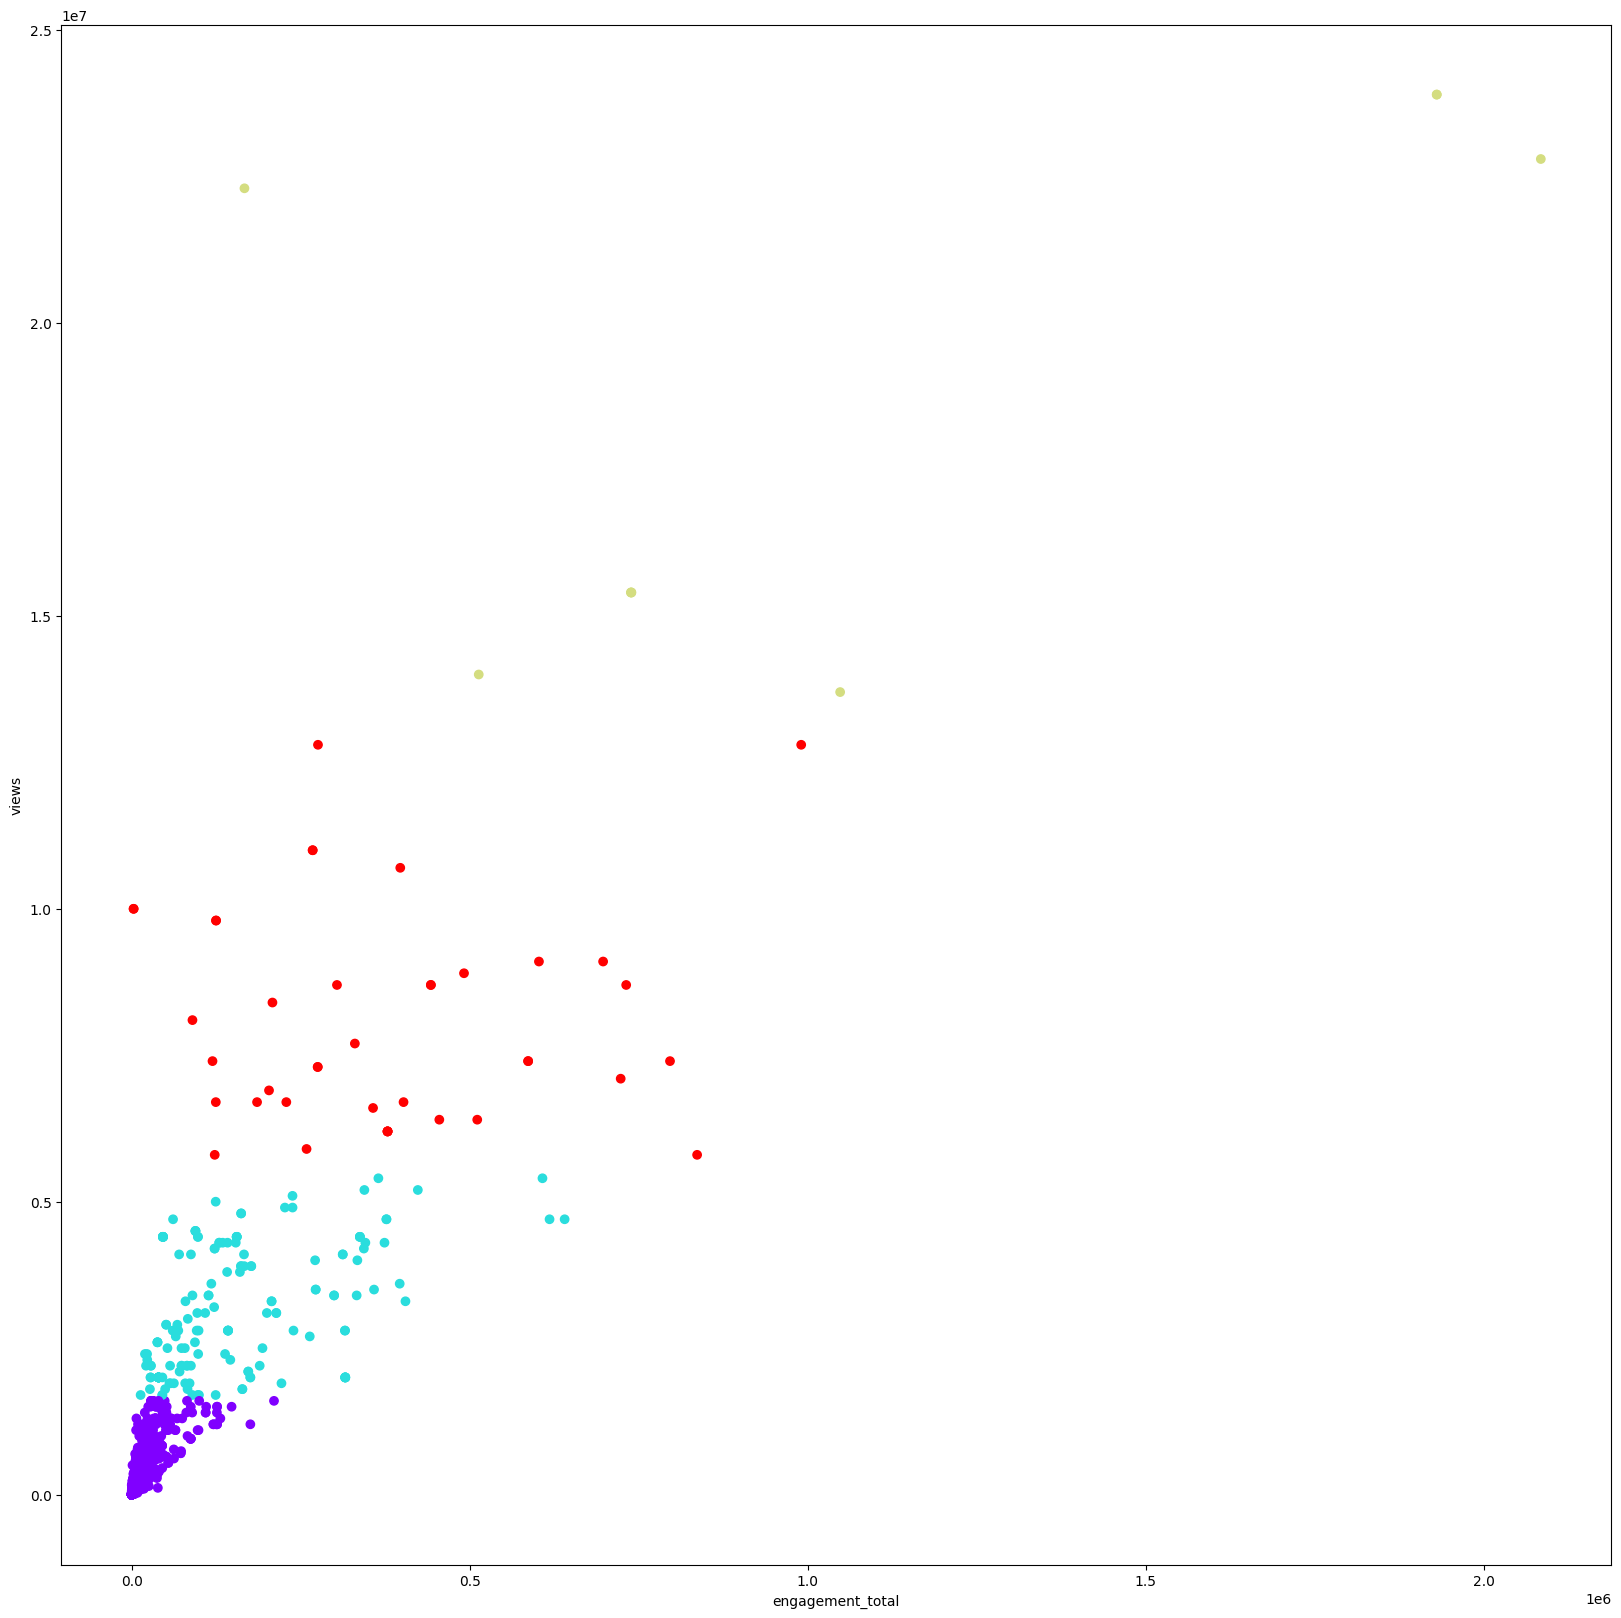

In [60]:
# visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.scatter(df['engagement_total'], df['views'], c=cluster.labels_, cmap='rainbow')
plt.xlabel('engagement_total')
plt.ylabel('views')
plt.show()


In [66]:
import json

def parse_json(data):
    return json.loads(json_util.dumps(data))

pipeline = [
    {
        '$group': {
            '_id': {
                'cluster': '$cluster',
                'label': '$label'
            },
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$group': {
            '_id': '$_id.cluster',
            'labelCounts': {
                '$push': {
                    'label': '$_id.label',
                    'count': '$count'
                }
            }
        }
    }
]
data_cluster = collection_cluster.aggregate([
    {
        '$match': {
            '$and': [
                {
                    'label': {
                        '$in': [
                            'partai amanat nasional', 'partai bulan bintang'
                        ]
                    }
                }, {
                    'cluster': {
                        '$in': [
                            1, 2
                        ]
                    }
                }
            ]
        }
    }
])
print(json.dumps(parse_json(data_cluster), indent=4, sort_keys=True))

[
    {
        "_id": {
            "$oid": "65646b8bdc6eeb57b85b0ff1"
        },
        "cluster": 1,
        "comment": 920,
        "engagement_total": 78564,
        "label": "partai amanat nasional",
        "like": 74700,
        "save": 2446,
        "share": 498,
        "tanggal": 1693406580,
        "url_video": "https://www.tiktok.com/@putri_zulhas/video/7273125872289221893",
        "views": 2500000
    },
    {
        "_id": {
            "$oid": "65646b8bdc6eeb57b85b0ff2"
        },
        "cluster": 1,
        "comment": 13200,
        "engagement_total": 358498,
        "label": "partai amanat nasional",
        "like": 325400,
        "save": 13700,
        "share": 6198,
        "tanggal": 1698207667,
        "url_video": "https://www.tiktok.com/@amanat_nasional/video/7293746378772155654",
        "views": 3500000
    },
    {
        "_id": {
            "$oid": "65646b8bdc6eeb57b85b0ff3"
        },
        "cluster": 1,
        "comment": 794,
        "engagemen